# Image Data Augmentation

This notebook can be used to do data augmentation on a set of test images.

It randomly applies the following augmentations:
* Horizontal shift
* Vertical shift
* Rotation
* Brightniss
* Zoom

In [1]:
from pathlib import Path

ROOT_DIR = Path().absolute().parent 
TEST_IMAGES_BASE = ROOT_DIR / "images"

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

# example of horizontal shift image augmentation
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Convert test images to grayscale

In [3]:
target_dir = TEST_IMAGES_BASE.parent / "images-augmented"
if not target_dir.is_dir():
    target_dir.mkdir(parents=True)

In [4]:
for image_path in TEST_IMAGES_BASE.iterdir():
    colored_image = cv2.imread(str(image_path), 0)
    cv2.imwrite(str(target_dir / image_path.name), colored_image)

## Create new trainings data

In [5]:
def show_generated_images(images):
    for i, image in enumerate(images):
        plt.subplot(330 + 1 + i)
        plt.imshow(image)
    plt.show()

In [6]:
def augment(image_path, count):
    img = load_img(image_path)
    data = img_to_array(img)
    # expand dimension to one sample
    samples = np.expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(
        width_shift_range=[-2, 2],
        height_shift_range=[-2, 2],
        rotation_range=10,
        brightness_range=[0.2, 1.0],
        zoom_range=0.2
    )
    it = datagen.flow(samples, batch_size=1)
    images = []
    for i in range(count):
        batch = it.next()
        image = batch[0].astype('uint8')
        images.append(image)
    return images

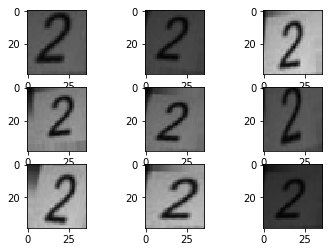

In [7]:
DEMO_IMAGE = TEST_IMAGES_BASE / "2_10.jpg"
    
images = augment(str(DEMO_IMAGE), count=9)
show_generated_images(images)

## Generate Test Images

In [8]:
AUGMENTATIONS_PER_IMAGE = 200

for image_path in target_dir.iterdir():
    augmented_images = augment(image_path, count=AUGMENTATIONS_PER_IMAGE)
    
    for i, augmented_image in enumerate(augmented_images):
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(str(image_path.parent / f"{image_path.stem}_augment_{i}.jpg"), augmented_image)

## Create Dataset

In [9]:
image_shape = (28, 28)

In [10]:
data = []
for i, image_path in enumerate(target_dir.iterdir()):
    image = cv2.imread(str(image_path), 0)
    image = cv2.resize(image, (28, 28))
    label = image_path.stem.split("_")[0]
    row = {"label": label}
    for p, pixel in enumerate(image.ravel()):
        row["pixel{}".format(p)] = pixel
    data.append(row)
    del image

print(f"Loaded {len(data)} images")
df = pd.DataFrame(data, columns=["label"] + ["pixel{}".format(i) for i in range(image_shape[0] * image_shape[1])])
df.head()

Loaded 152961 images


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,5,4,5,5,6,7,8,9,11,...,81,78,77,74,73,63,54,54,54,54
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,8,8,29,46,54,54,56,58,60,63,...,58,58,62,62,57,52,46,36,37,41
3,4,29,31,31,33,37,40,41,44,45,...,54,54,52,50,52,51,48,47,48,49
4,8,34,38,39,38,36,33,32,35,38,...,18,18,17,16,17,17,15,18,20,20


In [11]:
df.to_csv(target_dir / "dataset.csv", chunksize=1024)